In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
# sys.path.insert(0, os.path.abspath('./detectron2'))

# !pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-dmvclxup
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-dmvclxup
  Resolved https://github.com/facebookresearch/detectron2.git to commit b7c7f4ba82192ff06f2bbb162b9f67b00ea55867
  Preparing metadata (setup.py) ... done


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/bin/bash: line 1: nvcc: command not found
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# Train on a custom dataset

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/home/anand/Desktop/Detectron2/dataset2/train.json", "/home/anand/Desktop/Detectron2/dataset2/train")
register_coco_instances("my_dataset_val", {}, "/home/anand/Desktop/Detectron2/dataset2/val.json", "/home/anand/Desktop/Detectron2/dataset2/valid")



In [5]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[04/07 07:48:27 d2.data.datasets.coco]: Loaded 9534 images in COCO format from /home/anand/Desktop/Detectron2/dataset2/train.json


In [6]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")


[04/07 07:48:27 d2.data.datasets.coco]: Loaded 374 images in COCO format from /home/anand/Desktop/Detectron2/dataset2/val.json


In [7]:
from matplotlib import pyplot as plt

/home/anand/Desktop/Detectron2/dataset2/train/gray_mold96_jpg.rf.6cdf55cbdd13088e999dcc6682da36fa.jpg


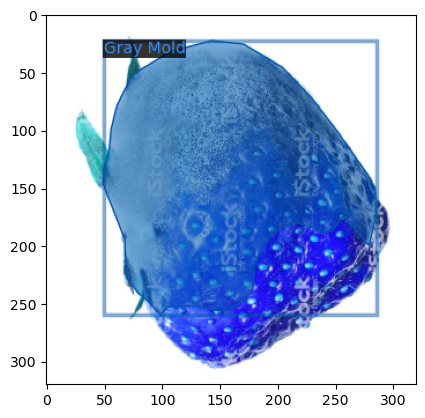

/home/anand/Desktop/Detectron2/dataset2/train/anthracnose_fruit_rot42_jpg.rf.eb0a2fd9e87ed5859d0e911d396527ba.jpg


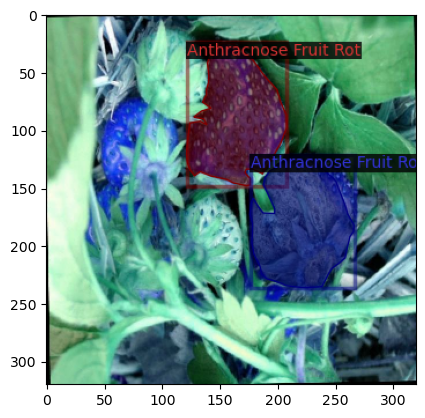

/home/anand/Desktop/Detectron2/dataset2/train/leaf_spot658_jpg.rf.76d62bbd8affbce2674de83e5d46b62c.jpg


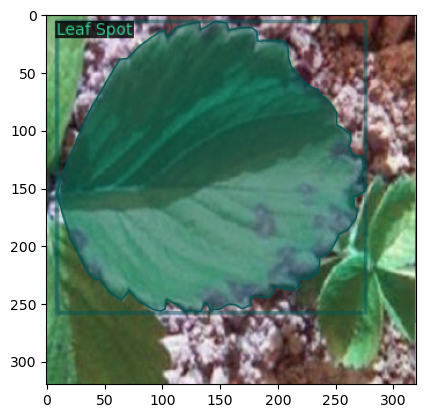

/home/anand/Desktop/Detectron2/dataset2/train/angular_leafspot306_jpg.rf.8d51db88441b6ad08a795040cc84248e.jpg


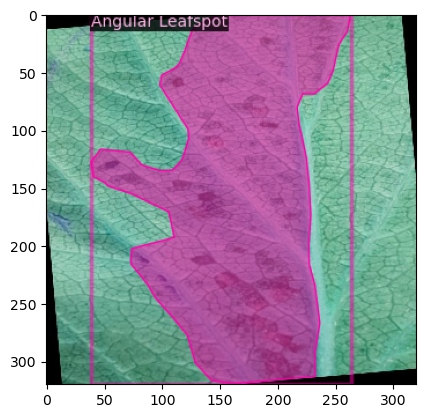

/home/anand/Desktop/Detectron2/dataset2/train/leaf_spot418_jpg.rf.bc4428ed9881336ffc8c9e03951fd71c.jpg


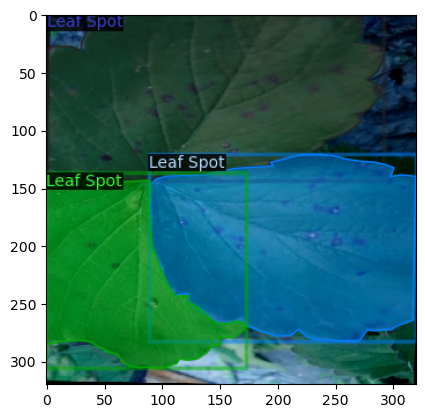

/home/anand/Desktop/Detectron2/dataset2/train/angular_leafspot9_jpg.rf.3a029021abb87a2b766d1e01db14e8d9.jpg


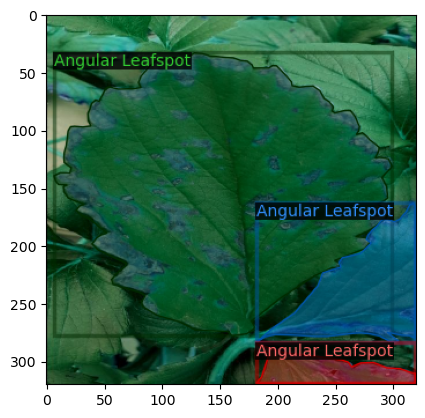

/home/anand/Desktop/Detectron2/dataset2/train/gray_mold375_jpg.rf.6f327fcd8327a76f75e701ee07312873.jpg


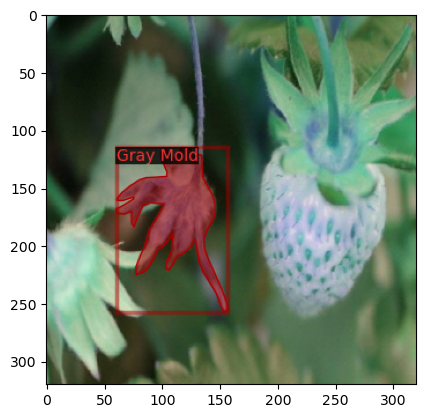

/home/anand/Desktop/Detectron2/dataset2/train/powdery_mildew_leaf332_jpg.rf.f79a147acfa92a96abda30ccb90755b2.jpg


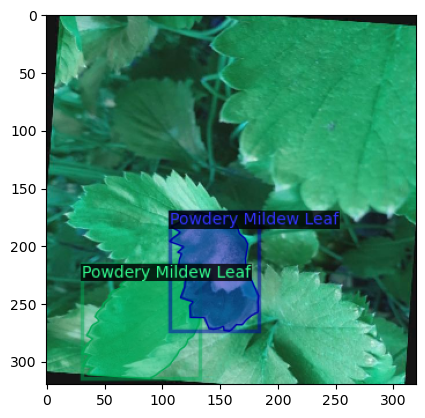

/home/anand/Desktop/Detectron2/dataset2/train/leaf_spot256_jpg.rf.d273a0100ecaf4bf6b4c906edfc04afb.jpg


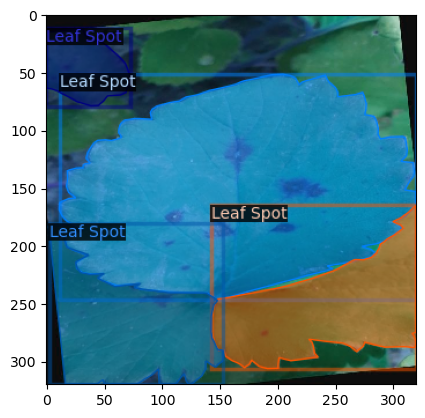

/home/anand/Desktop/Detectron2/dataset2/train/powdery_mildew_leaf379_jpg.rf.ac681d32ccda24886e1d45680c04e3b3.jpg


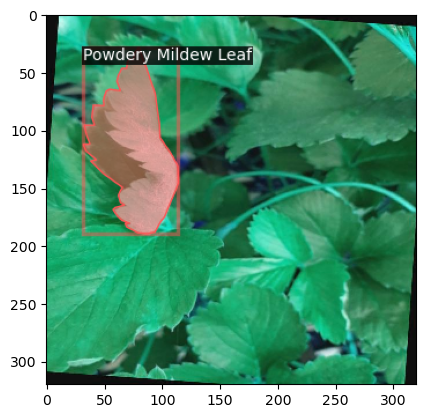

In [8]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [9]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/home/anand/Desktop/Detectron2/Detectron2_Models_augmented"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 20000   # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 640   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # We have 7 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[04/07 07:48:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) 

Train

In [15]:
trainer.train() #Start the training process

[04/06 21:48:36 d2.engine.train_loop]: Starting training from iteration 0


/home/anand/anaconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/06 21:48:51 d2.utils.events]:  eta: 3:59:23  iter: 19  total_loss: 3.111  loss_cls: 2.167  loss_box_reg: 0.1719  loss_mask: 0.6938  loss_rpn_cls: 0.04962  loss_rpn_loc: 0.01496    time: 0.7224  last_time: 0.7148  data_time: 0.0074  last_data_time: 0.0026   lr: 4.9953e-06  max_mem: 1767M
[04/06 21:49:06 d2.utils.events]:  eta: 4:01:28  iter: 39  total_loss: 2.85  loss_cls: 1.944  loss_box_reg: 0.1241  loss_mask: 0.6918  loss_rpn_cls: 0.08486  loss_rpn_loc: 0.01872    time: 0.7231  last_time: 0.7865  data_time: 0.0028  last_data_time: 0.0030   lr: 9.9902e-06  max_mem: 1843M
[04/06 21:49:20 d2.utils.events]:  eta: 3:57:29  iter: 59  total_loss: 2.354  loss_cls: 1.465  loss_box_reg: 0.1437  loss_mask: 0.6907  loss_rpn_cls: 0.02956  loss_rpn_loc: 0.01386    time: 0.7128  last_time: 0.7954  data_time: 0.0028  last_data_time: 0.0028   lr: 1.4985e-05  max_mem: 1843M
[04/06 21:49:34 d2.utils.events]:  eta: 3:57:43  iter: 79  total_loss: 1.776  loss_cls: 0.8384  loss_box_reg: 0.1466  loss_ma

Save the config file, for potential future use

In [10]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/home/anand/Desktop/Detectron2/Detectron2_Models_augmented/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [11]:

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/07 07:48:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/anand/Desktop/Detectron2/Detectron2_Models_augmented/model_final.pth ...


Verify segmentation on random validation images

/home/anand/Desktop/Detectron2/dataset2/valid/angular_leafspot229_jpg.rf.17b4a7cadc58c97d8f675d68e4fb811b.jpg


/home/anand/anaconda3/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


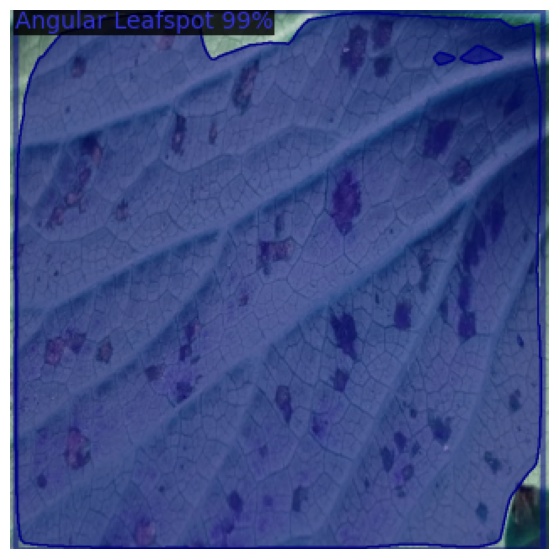

/home/anand/Desktop/Detectron2/dataset2/valid/angular_leafspot322_jpg.rf.c9cec3422e25096412710ae095bb4600.jpg


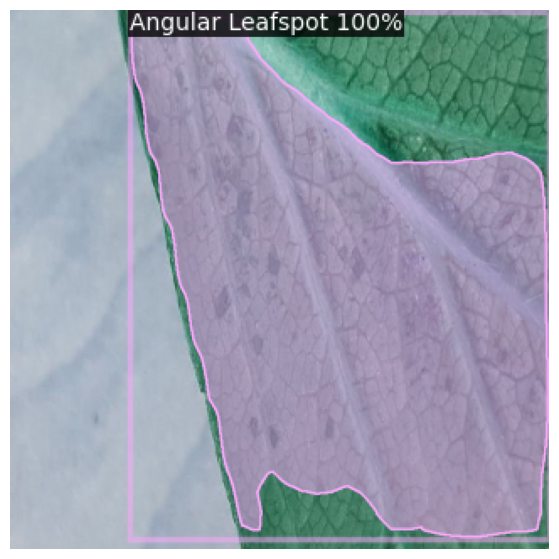

/home/anand/Desktop/Detectron2/dataset2/valid/leaf_spot81_jpg.rf.c213d36c6506386624437927ac765b11.jpg


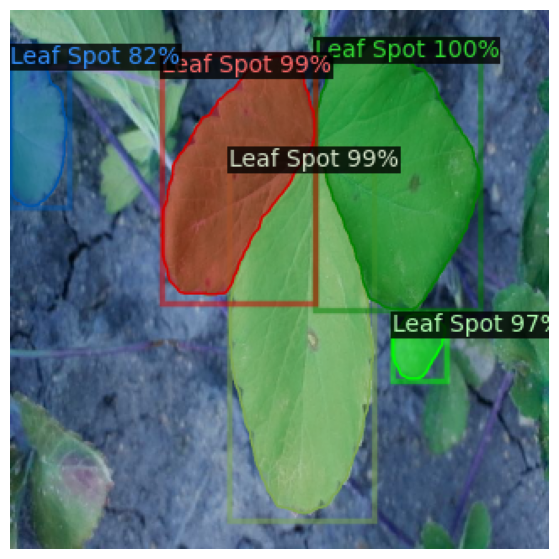

/home/anand/Desktop/Detectron2/dataset2/valid/powdery_mildew_leaf467_jpg.rf.50869ee174dec45b74d48273ff6e738a.jpg


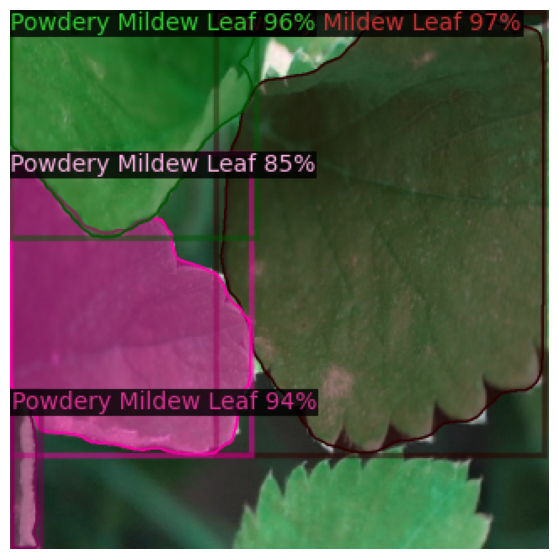

/home/anand/Desktop/Detectron2/dataset2/valid/anthracnose_fruit_rot50_jpg.rf.95d2bbad4a7b5e77c67ca6965011cb18.jpg


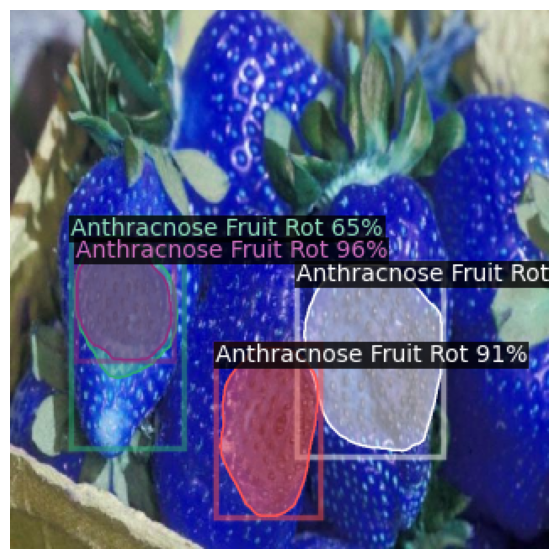

/home/anand/Desktop/Detectron2/dataset2/valid/leaf_spot359_jpg.rf.40d0b8746d09fe80bcafe5c54c3f7e64.jpg


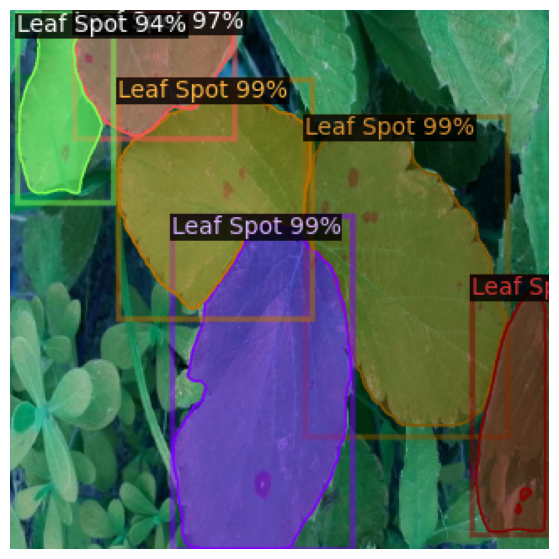

/home/anand/Desktop/Detectron2/dataset2/valid/blossom_blight129_jpg.rf.fc8bb7e2afe642fe79d0a3baaead4f4e.jpg


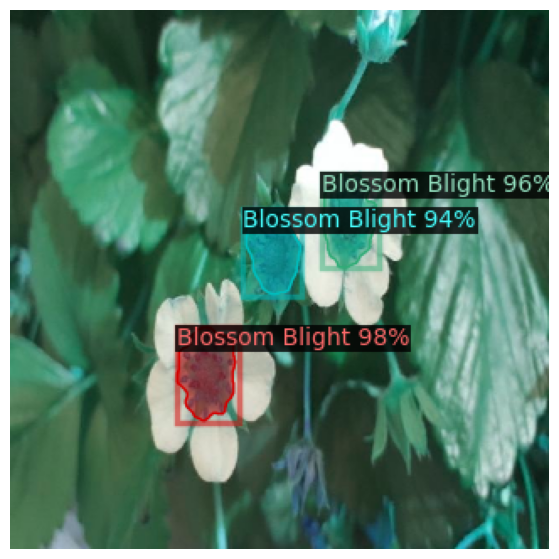

/home/anand/Desktop/Detectron2/dataset2/valid/gray_mold328_jpg.rf.27c608f5b94c3eac0ab8ee7c7403a594.jpg


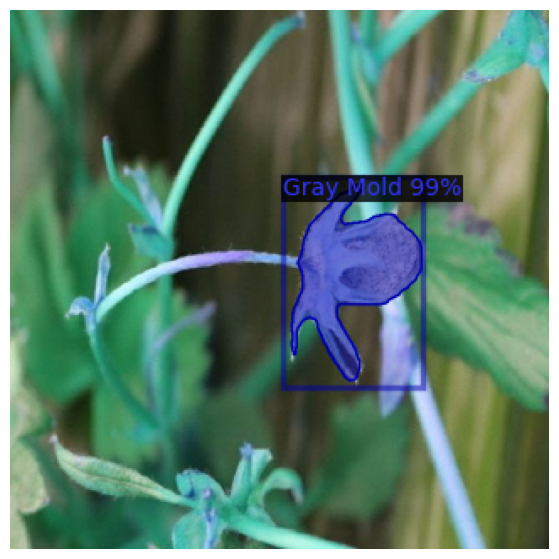

/home/anand/Desktop/Detectron2/dataset2/valid/powdery_mildew_leaf456_jpg.rf.06e32a6d2d430e6a59b0e3bfa40df3d5.jpg


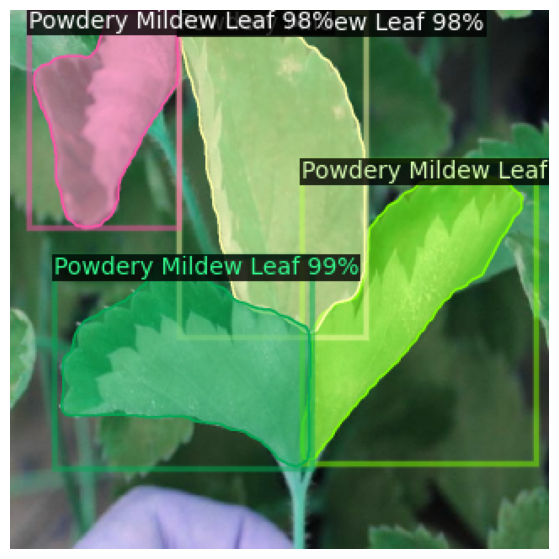

/home/anand/Desktop/Detectron2/dataset2/valid/angular_leafspot287_jpg.rf.82a5817c385b487bdb7e975153fbd3ec.jpg


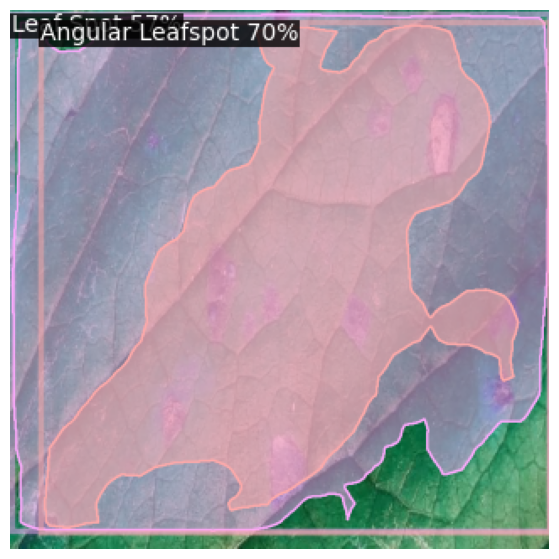

In [12]:
# from detectron2.utils.visualizer import ColorMode

# for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
#     im = cv2.imread(d["file_name"])
#     outputs = predictor(im)
#     v = Visualizer(im[:, :, ::-1],
#                    metadata=val_metadata,
#                    scale=0.5,
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
#     )
#     out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     cv2_imshow(out.get_image()[:, :, ::-1])




from detectron2.utils.visualizer import ColorMode

import matplotlib.pyplot as plt

for d in random.sample(val_dataset_dicts, 10):    #select number of images for display
    im = cv2.imread(d["file_name"])
    print(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.figure(figsize=(10, 7))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


Check average precision and recall. (Need more validation data than just 2 images with handful of annotations)

In [27]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[04/06 19:00:26 d2.data.datasets.coco]: Loaded 374 images in COCO format from /home/anand/Desktop/Detectron2/dataset2/val.json
[04/06 19:00:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/06 19:00:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/06 19:00:26 d2.data.common]: Serializing 374 elements to byte tensors and concatenating them all ...
[04/06 19:00:26 d2.data.common]: Serialized dataset takes 0.93 MiB
[04/06 19:00:26 d2.evaluation.evaluator]: Start inference on 374 batches
[04/06 19:00:28 d2.evaluation.evaluator]: Inference done 11/374. Dataloading: 0.0010 s/iter. Inference: 0.1538 s/iter. Eval: 0.0021 s/iter. Total: 0.1569 s/iter. ETA=0:00:56
[04/06 19:00:33 d2.evaluation.evaluator]: Inference done 44/374. Dataloading: 0.0010 s/iter. Inference: 0.1523 s/iter. Eval: 0.0017 s/iter. Total: 0.1551 s/i

In [13]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score

# Create COCOEvaluator and load validation data
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

# Perform inference
results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Print mAP
print("Mean Average Precision (mAP):", results["bbox"]["AP"])



[04/07 07:49:08 d2.data.datasets.coco]: Loaded 374 images in COCO format from /home/anand/Desktop/Detectron2/dataset2/val.json
[04/07 07:49:08 d2.data.build]: Distribution of instances among all 7 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| Angular Lea.. | 69           | Anthracnose.. | 27           | Blossom Bli.. | 46           |
|   Gray Mold   | 103          |   Leaf Spot   | 324          | Powdery Mil.. | 50           |
| Powdery Mil.. | 253          |               |              |               |              |
|     total     | 872          |               |              |               |              |
[04/07 07:49:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/07 07:49:08 d2.data.common]: Serializi

**Load a new image and segment it.**

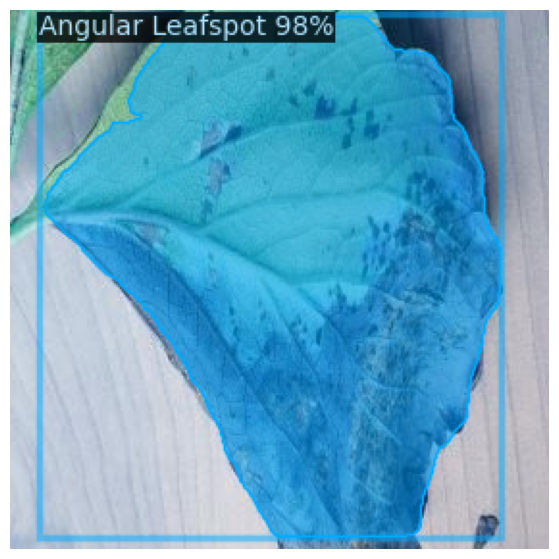

In [20]:
new_im = cv2.imread("/home/anand/Desktop/Detectron2/dataset/test/angular_leafspot81_jpg.rf.f5561a7aad238fc843f199f19e680a7d.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(10, 7))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

# cv2_imshow(out.get_image()[:, :, ::-1])


Confsion matrix


In [14]:
import pandas as pd
import numpy as np
import torch
import cv2
from detectron2.structures import Boxes, pairwise_iou
import seaborn as sns
import matplotlib.pyplot as plt

train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

# For validation
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")


# Define functions for bounding box conversion and confusion matrix calculation
def coco_bbox_to_coordinates(bbox):
    out = bbox.copy().astype(float)
    out[:, 2] = bbox[:, 0] + bbox[:, 2]
    out[:, 3] = bbox[:, 1] + bbox[:, 3]
    return out

def conf_matrix_calc(labels, detections, n_classes, conf_thresh, iou_thresh):
    confusion_matrix = np.zeros([n_classes + 1, n_classes + 1])
    l_classes = np.array(labels)[:, 0].astype(int)
    l_bboxs = coco_bbox_to_coordinates((np.array(labels)[:, 1:]))
    d_confs = np.array(detections)[:, 4]
    d_bboxs = (np.array(detections)[:, :4])
    d_classes = np.array(detections)[:, -1].astype(int)
    detections = detections[np.where(d_confs > conf_thresh)]
    labels_detected = np.zeros(len(labels))
    detections_matched = np.zeros(len(detections))
    for l_idx, (l_class, l_bbox) in enumerate(zip(l_classes, l_bboxs)):
        for d_idx, (d_bbox, d_class) in enumerate(zip(d_bboxs, d_classes)):
            iou = pairwise_iou(Boxes(torch.from_numpy(np.array([l_bbox]))), Boxes(torch.from_numpy(np.array([d_bbox]))))
            if iou >= iou_thresh:
                confusion_matrix[l_class, d_class] += 1
                labels_detected[l_idx] = 1
                detections_matched[d_idx] = 1
    for i in np.where(labels_detected == 0)[0]:
        confusion_matrix[l_classes[i], -1] += 1
    for i in np.where(detections_matched == 0)[0]:
        confusion_matrix[-1, d_classes[i]] += 1
    return confusion_matrix

# Modify the loop to integrate confusion matrix calculation
n_classes = 6
confusion_matrix = np.zeros([n_classes + 1, n_classes + 1])

for d in val_dataset_dicts:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    labels = []
    detections = []
    for coord, conf, cls, ann in zip(
        outputs["instances"].get("pred_boxes").tensor.cpu().numpy(),
        outputs["instances"].get("scores").cpu().numpy(),
        outputs["instances"].get("pred_classes").cpu().numpy(),
        d["annotations"]
    ):
        labels.append([ann["category_id"]] + ann["bbox"])
        detections.append(list(coord) + [conf] + [cls])
    
    # Check if labels are available
    if labels:
        # Calculate confusion matrix for each image
        confusion_matrix += conf_matrix_calc(np.array(labels), np.array(detections), n_classes, conf_thresh=0.5, iou_thresh=0.5)

print(confusion_matrix)

# # Convert the confusion matrix to a DataFrame for easier visualization
# matrix_indexes = metadata_train.get("my_dataset_val") + ["null"]
# confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=matrix_indexes, index=matrix_indexes)
# print(confusion_matrix_df)


matrix_indexes = val_metadata.get("my_dataset_val") 
confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=matrix_indexes, index=matrix_indexes)
print(confusion_matrix_df)



[04/07 07:50:07 d2.data.datasets.coco]: Loaded 9534 images in COCO format from /home/anand/Desktop/Detectron2/dataset2/train.json
[04/07 07:50:08 d2.data.datasets.coco]: Loaded 374 images in COCO format from /home/anand/Desktop/Detectron2/dataset2/val.json
[[ 62.   0.   0.   0.   1.   0.   1.]
 [  0.  16.   0.   0.   0.   0.   8.]
 [  0.   0.  44.   0.   0.   0.   2.]
 [  0.   1.   0.  83.   0.   1.   9.]
 [  0.   0.   0.   0. 287.   0.  27.]
 [  0.   0.   0.   5.   0.  30.   5.]
 [  1.   6.   2.   9.  35.   4. 279.]]
      0     1     2     3      4     5      6
0  62.0   0.0   0.0   0.0    1.0   0.0    1.0
1   0.0  16.0   0.0   0.0    0.0   0.0    8.0
2   0.0   0.0  44.0   0.0    0.0   0.0    2.0
3   0.0   1.0   0.0  83.0    0.0   1.0    9.0
4   0.0   0.0   0.0   0.0  287.0   0.0   27.0
5   0.0   0.0   0.0   5.0    0.0  30.0    5.0
6   1.0   6.0   2.0   9.0   35.0   4.0  279.0


In [1]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# # Construct confusion matrix DataFrame with class names
# confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=matrix_indexes, index=matrix_indexes)
# print(confusion_matrix_df)

# class_names = {
#     0: 'Angular Leafspot',
#     1: 'Anthracnose Fruit Rot',
#     2: 'Blossom Blight',
#     3: 'Gray Mold',
#     4: 'Leaf Spot',
#     5: 'Powdery Mildew Fruit',
#     6: 'Powdery Mildew Leaf',
    
# }

# # Visualize confusion matrix as heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', fmt='g')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


In [2]:
# plt.figure(figsize=(6, 4))
# sns.heatmap(confusion_matrix_df, annot=True, fmt='g', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


In [4]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming you have already created the confusion_matrix_df DataFrame

# class_names = {
#     0: 'Angular Leafspot',
#     1: 'Anthracnose Fruit Rot',
#     2: 'Blossom Blight',
#     3: 'Gray Mold',
#     4: 'Leaf Spot',
#     5: 'Powdery Mildew Fruit',
#     6: 'Powdery Mildew Leaf'
# }

# # Create a function to map labels
# def map_labels(label):
#     return class_names[label]

# # Apply the mapping function to the columns and index
# confusion_matrix_df.columns = confusion_matrix_df.columns.map(map_labels)
# confusion_matrix_df.index = confusion_matrix_df.index.map(map_labels)

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", fmt="d")
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


In [3]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Sample data in a DataFrame
# data = pd.DataFrame([[1, 2, 3],
#                      [4, 5, 6],
#                      [7, 8, 9]])

# # Plotting the heatmap with transposed DataFrame
# sns.heatmap(data, annot=True, cmap='viridis', fmt='d')

# plt.show()
